In [110]:
import os
import torch
import re
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torch import nn;
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab

DATA_DIR = './data/'
DOCS_DIR = './docs/'
MIN_WORD_FREQUENCY = 100
FORCE_RETRAIN = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Tokenize datasets

In [ ]:
TOKENIZER = get_tokenizer('basic_english')

def read_lines(
    dataset: str
) -> list[str]:
    """
    Reads all the lines form all the texts in the given `dataset`.

    Datasets are `train`, `val` and `test`.
    """

    # Scan for all input files
    inDirectoryName = os.path.join(DATA_DIR, 'input', dataset)
    inFileNames = [os.path.join(inDirectoryName, f) for f in os.listdir(inDirectoryName)]

    # Read all the lines from all the files
    lines = []
    for inFileName in inFileNames:
        with open(inFileName, 'r') as file:
            lines += file.readlines()

    print(f"Read {len(lines)} lines from {dataset}")
    return lines

def create_tokens(
    dataset: str
) -> list[str]:
    """
    Creates tokens for all the words in the given `dataset`.

    Datasets are `train`, `val` and `test`.
    """

    outFileName = os.path.join(DATA_DIR, f'words.{dataset}.pt')
    
    # If the file exists, don't create it again.
    if os.path.isfile(outFileName):
        print(f"Loaded tokenized words for {dataset} ({outFileName})")
        return torch.load(outFileName)

    tokens = []
    for line in read_lines(dataset):
        tokens += TOKENIZER(line)

    # Save tokens so we dont have to do this again
    torch.save(tokens, outFileName)
    
    return tokens

def create_vocabulary(
    dataset: str
) -> Vocab:
    """
    Creates a vocabulary for the given `dataset`.

    Datasets are `train`, `val` and `test`.
    """

    outFileName = os.path.join(DATA_DIR, f'vocabulary.pt')

    # If the file exists, don't create it again.
    if os.path.isfile(outFileName):
        print(f"Loaded vocabulary for {dataset} ({outFileName})")
        return torch.load(outFileName)

    def read_sanitize_tokenize():

        for line in read_lines(dataset):

            line = re.sub('\\w*[0-9]+\\w*', ' ', line) # Remove numbers
            line = re.sub('\\w*[A-Z]+\\w*', ' ', line) # Remove uppercase names
            line = re.sub('\\s+', ' ', line) # Remove double spaces

            yield TOKENIZER(line)

    vocabulary = build_vocab_from_iterator(read_sanitize_tokenize(), min_freq=MIN_WORD_FREQUENCY, specials=['<unk>'])

    vocabulary.set_default_index(vocabulary['<unk>'])

    # We removed all uppercase names, this includes 'I'
    vocabulary.append_token('i') 

    # Save vocabulary so we dont have to do this again
    torch.save(vocabulary, outFileName)

    return vocabulary
    


In [ ]:
words_train = create_tokens('train')
words_val = create_tokens('val')
words_test = create_tokens('test')

vocabulary = create_vocabulary('train')
VOCABULARY_SIZE = len(vocabulary)

Words in 'train' dataset ........: 2684706
Words in 'val' dataset ..........: 49526
Words in 'test' dataset .........: 124152
Distinct words in 'train' dataset: 52105
Words in vocabulary .............: 1880


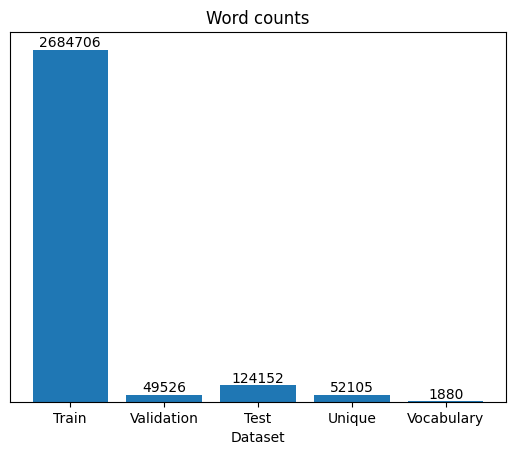

<Figure size 640x480 with 0 Axes>

In [25]:

def print_dataset_info():
    print("Words in 'train' dataset ........:", len(words_train))
    print("Words in 'val' dataset ..........:", len(words_val))
    print("Words in 'test' dataset .........:", len(words_test))
    print("Distinct words in 'train' dataset:", len(set(words_train)))
    print("Words in vocabulary .............:", VOCABULARY_SIZE)

    bars = plt.bar(['Train', 'Validation', 'Test', 'Unique', 'Vocabulary'], [len(words_train), len(words_val), len(words_test), len(set(words_train)), VOCABULARY_SIZE])
    plt.title('Word counts')
    plt.xlabel('Dataset')
    plt.ylabel('Word count')
    plt.gca().yaxis.set_visible(False)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    plt.savefig(DOCS_DIR + 'word_counts.png')
    plt.show()
    plt.clf()
print_dataset_info()

# Utilities
This section contains som utilites which come in handy for all the next assignments.

In [159]:
def model_nameof(
    model: nn.Module, 
    criterion: object, 
    optimizer: torch.optim.Optimizer
) -> str:
    """
    Creates a good name for the model.
    """

    name = f'{model.__class__.__name__}_{criterion.__class__.__name__}_{optimizer.__class__.__name__}'
    options = optimizer.param_groups[0]

    if 'lr' in options:
        name += f'-lr{options["lr"]:.4f}'

    if 'momentum' in options and options['momentum'] != 0.0:
        name += f'-m{options["momentum"]:.4f}'

    if 'weight_decay' in options and options['weight_decay'] != 0.0:
        name += f'-wd{options["weight_decay"]:.4f}'

    return name

def model_save(model: nn.Module, folder: str | None = None):
    """
    Save the given model to a file.
    """

    folder = '' if folder is None else folder + '/'
    filename = DATA_DIR + f'{folder}{model.name}.pt'

    torch.save(model.state_dict(), filename)
    print(f'Saved {model.name} ({filename})')

def model_load(model: nn.Module, folder: str | None = None) -> bool:
    """
    Save the given model to a file.

    Returns `True` if the model was loaded, `False` otherwise.
    """

    if FORCE_RETRAIN:
        return False

    folder = '' if folder is None else folder + '/'
    filename = DATA_DIR + f'{folder}{model.name}.pt'

    if not os.path.exists(filename):
        return False
    
    model.load_state_dict(torch.load(filename))
    print(f'Loaded {model.name} ({filename}')
    return True

def dataset_create(
    words: list[str],
    context_size_before: int = 0,
    context_size_after: int = 0,
    vocabulary_index_to_target: dict[int, int] = {},
    dataset_name: str | None = None
) -> TensorDataset:
    """
    Creates a dataset from the given words.
    """

    # Convert in case they are floats
    context_size_before = int(context_size_before)
    context_size_after = int(context_size_after)

    filename = DATA_DIR + f'dataset/{dataset_name}.pt'
    if os.path.exists(filename) and dataset_name is not None and not FORCE_RETRAIN:
        return torch.load(filename)

    word_idx = [vocabulary[word] for word in words]

    contexts = []
    targets = []
    for i in range(context_size_before, len(words) - context_size_after - 1):

        context_before = word_idx[i-context_size_before:i]
        context_after = word_idx[i+1:i+1+context_size_after]
        context = context_before + context_after
        target = word_idx[i+context_size_before]
        target = vocabulary_index_to_target.get(target, None)

        if target is not None:
            contexts.append(torch.tensor(context))
            targets.append(target)

    contexts = torch.stack(contexts).to(device)
    targets = torch.tensor(targets).to(device)

    dataset = TensorDataset(contexts, targets)
    torch.save(dataset, filename)

    return dataset


def model_train(
    model: nn.Module,
    dataset: TensorDataset,
    criterion: typing.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    optimizer: torch.optim.Optimizer,
    batch_size: int,
    epochs: int,
    tranform_targets: typing.Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    tranform_contexts: typing.Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    model_category: str = "models",
    retrain: bool = False,
    figure_tag: str = ""
) -> list[float]:
    """
    Trains the given `model` with the given `dataset`.  

    dataset: The dataset to train the model with.
    model: The model to train.
    criterion: The loss function to use.
    optimizer: The optimizer to use.
    batch_size: The batch size to use.
    epochs: The number of epochs to train.
    force_retrain: If `True`, the model will be trained even if it has been trained before.
    tranform_targets: A function to transform the targets before they are passed to `criterion` along with the `model` output.
    tranform_contexts: A function to transform the contexts before they are passed to `model`.
    model_category: The category of the model. If `None`, the model's class name will be used.
    """
    criterion.to(device)
    model.to(device)
    model.train()

    # Name the model for easier referencing
    model.name = model_nameof(model, criterion, optimizer)

    # If the model has already been trained,
    # and we are not forcing a retrain:
    #     Load the trained model and return
    if (not retrain) and model_load(model, model_category):
        return []
    
    # Prepare a data loader for the given dataset.
    # Ensure the data is shuffled.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f'Training {model.name}...')

    losses = []
    dataset_size = dataset.tensors[0].size(0)

    for epoch in range(epochs):
        loss_sum = torch.tensor([0.0]).to(device)

        for contexts, targets in data_loader:

            # Perform transformations
            contexts = tranform_contexts(contexts).to(device)
            targets = tranform_targets(targets).to(device)

            # Perform a training step
            optimizer.zero_grad()
            outputs = model(contexts).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            loss_sum += loss

        loss_sum = loss_sum.item() / dataset_size
        losses.append(loss_sum)
        print(f'Training | {model.name} | Epoch {epoch} | Loss {loss_sum}')

    plt.clf()
    plt.plot(losses)
    plt.title(f'{model.name} | Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(DOCS_DIR + f'loss_{model.name}{figure_tag}.png')

    # Save the model so we can skip training every time.
    model_save(model, model_category)

    return losses


def model_accuracy(
    model: nn.Module,
    dataset: TensorDataset,
    dataset_name: str = 'Validation',
    transform_contexts: typing.Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    transform_outputs: typing.Callable[[torch.Tensor], torch.Tensor] = lambda x: x
):
    """
    Evaluate the given model on the given dataset.

    Returns the accuracy of the model.
    """

    model.to(device)
    model.eval()

    data_loader = DataLoader(dataset, shuffle=False)

    correct = 0
    total = 0

    for contexts, targets in data_loader:
        contexts = transform_contexts(contexts).to(device)
        outputs = model(contexts)
        outputs = transform_outputs(outputs)

        total += targets.size(0)
        correct += (outputs == targets).sum().item()

    print(f'{dataset_name} | {model.name} | Accuracy {correct/total:.4f}')

    return correct / total

def model_pick_best(
    models: list[nn.Module],
    dataset: TensorDataset,
    performance_measure: typing.Callable[[nn.Module, TensorDataset], float],
    figure_tag: str = ""
):
    """
    Pick the best model from the given list of `models` on a given `dataset`.
    """

    best_model = None
    best_accuracy = 0.0

    accuracies: dict[str, float] = {}

    for model in models:
        accuracy = performance_measure(model, dataset)
        accuracies[model.name] = accuracy

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    print(f'Best model: {best_model.name} | Accuracy {best_accuracy:.4f}')

    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    bars = plt.bar(accuracies.keys(), accuracies.values(), color=colors[:len(accuracies)])
    plt.title('Model Accuracy')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.gca().xaxis.set_visible(False)
    plt.legend(bars, accuracies.keys())
    plt.gca().yaxis.set_visible(False)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    plt.savefig(DOCS_DIR + f'accuracy{figure_tag}.png')

    return best_model, best_accuracy

# Word embeddings
This section contains the training and selecting of the best performing embeddings using `CBOW`.

In [ ]:
EMBEDDINGS_DIM = 32
EMBEDDINGS_CONTEXT_SIZE = 5
EMBEDDINGS_BATCH_SIZE = 128
EMBEDDINGS_EPOCHS = 100

class CBOW(nn.Module):
    def __init__(self):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(VOCABULARY_SIZE, EMBEDDINGS_DIM, sparse=True)
        self.linear = nn.Linear(EMBEDDINGS_DIM*EMBEDDINGS_CONTEXT_SIZE, VOCABULARY_SIZE)

    def forward(self, x):
        x = self.embeddings(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = torch.log_softmax(x, dim=1)
        return x

def cbow_create_dataset(
    words: list[str],
    dataset_name: str
):
    """
    Creates a dataset from the given words.
    """
    return dataset_create(words, EMBEDDINGS_CONTEXT_SIZE, dataset_name='cbow.' + dataset_name)

def cbow_train(
    dataset: TensorDataset,
    model: CBOW,
    criterion: object,
    optimizer: torch.optim.Optimizer,
):
    return model_train(
        model, dataset, criterion, optimizer, 
        model_category='embeddings',
        epochs=EMBEDDINGS_EPOCHS, batch_size=EMBEDDINGS_BATCH_SIZE,
        tranform_targets=lambda x: torch.nn.functional.one_hot(x, num_classes=VOCABULARY_SIZE).float()
    )

def cbow_performance(
    model: CBOW,
    dataset: TensorDataset,
    dataset_name: str = 'Validation'
):
    return model_accuracy(
        model, dataset, dataset_name,
        transform_outputs=lambda x: torch.argmax(x, dim=1)
    )

def cbow_create_embeddings() -> torch.Tensor:
    """
    Create multiple embeddings models and pick the best one.  

    Returns the embeddings of the best model.
    """
    training_data = cbow_create_dataset(words_train, 'train')

    m1 = CBOW()
    cbow_train(
        training_data, m1,
        nn.CrossEntropyLoss(),
        torch.optim.SGD(m1.parameters(), lr=0.02)
    )

    m2 = CBOW()
    cbow_train(
        training_data, m2,
        nn.CrossEntropyLoss(),
        torch.optim.SGD(m2.parameters(), lr=0.01)
    )
    
    m3 = CBOW()
    cbow_train(
        training_data, m3,
        nn.CrossEntropyLoss(),
        torch.optim.SGD(m3.parameters(), lr=0.001)
    )
    
    m4 = CBOW()
    cbow_train(
        training_data, m4,
        nn.CrossEntropyLoss(),
        torch.optim.Adam(m4.parameters(), lr=0.02)
    )
    
    m5 = CBOW()
    cbow_train(
        training_data, m5,
        nn.CrossEntropyLoss(),
        torch.optim.Adam(m5.parameters(), lr=0.002)
    )

    validation_data = cbow_create_dataset(words_val, 'val')
    best_model, best_model_accuracy = model_pick_best(
        [m1, m2, m3, m4, m5],
        dataset = validation_data,
        performance_measure=cbow_performance,
        figure_tag='cbow'
    )

    return best_model.embeddings.weight.detach().to(device)

In [53]:
# embeddings = cbow_create_embeddings()
embeddings = torch.load(DATA_DIR + 'embeddings.pt')

## Insepecting the embeddings
In this section we try to understand the embeddings we created in the previous section.  
We will identify which words the model believes are similar and take a look at the embeddings using the `Tensorflow Projector` tool.

In [ ]:
def word_vector_similarity_cosine(word_a:torch.Tensor, word_b:torch.Tensor):
    return torch.dot(word_a, word_b) / (word_a.norm() * word_b.norm())

def word_vector_similarity_euclidian(word_a:torch.Tensor, word_b:torch.Tensor):
    return (word_a - word_b).norm()

def word_similarity_cosine(word_a:str, word_b:str):
    word_a_idx = vocabulary[word_a]
    word_b_idx = vocabulary[word_b]

    word_a_embedding = embeddings[word_a_idx]
    word_b_embedding = embeddings[word_b_idx]

    return word_vector_similarity_cosine(word_a_embedding, word_b_embedding)

def word_find_top_closest(
    word: str,
    top: int
):
    similarities = []
    for other in vocabulary.lookup_tokens(range(len(vocabulary))):
        similarity = word_similarity_cosine(word, other).item()
        similarities.append((other, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    similarities = similarities[1:top+1]

    return similarities

def word_find_closest(
    word_vector:torch.Tensor,
):
    closest_word = None
    closest_distance = 1_000_000

    for other in vocabulary.lookup_tokens(range(len(vocabulary))):
        other_idx = vocabulary[other]
        other_embedding = embeddings[other_idx]

        distance = word_vector_similarity_euclidian(word_vector, other_embedding)

        if distance < closest_distance:
            closest_distance = distance
            closest_word = other
    
    return closest_word

In [ ]:
def print_most_similar_words(words, top = 10):
    print(f"Top {top} most similar words")
    for word in words:
        if vocabulary[word] == vocabulary['<unk>']:
            print(word, ':', "Not in vocabulary")
        else:
            print(word, ':', [x[0] for x in word_find_top_closest(word, top)])

print_most_similar_words([
    'king', 'queen', 'man', 'woman', 'he', 'she', 'doctor', 'nurse',
    'black', 'white', 'slave', 'master',
    'poor', 'rich', 
    'smart', 'dumb', 
    'strong', 'weak',
    'good', 'bad',
])

In [ ]:
def tensorflow_projector_create_data():
    e = embeddings.cpu().numpy()
    e = pd.DataFrame(e)
    e.to_csv(DATA_DIR + 'tensorflow_projector/embeddings.tsv', sep='\t', index=False, header=False)

    v = vocabulary.lookup_tokens(range(len(vocabulary)))
    v = pd.DataFrame(v)
    v.to_csv(DATA_DIR + 'tensorflow_projector/vocabulary.tsv', sep='\t', index=False, header=False)

tensorflow_projector_create_data()

# Conjugating _be_ and _have_

Training be/have models
Context size: 0 torch.Size([124029, 20])
Training BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010...
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 0 | Loss 0.00030469634901256714
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 1 | Loss 0.000259993937102632
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 2 | Loss 0.0002048152633888562
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 3 | Loss 0.00014921204240221636
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 4 | Loss 0.00010215866555996827
Saved BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 (./data/behave/BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010.pt)
Context size: 1 torch.Size([124029, 18])
Training BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010...
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 0 | Loss 0.00028144739173745404
Training | BeHaveRNN_CrossEntropyLoss_Adam-lr0.0010 | Epoch 1 | Loss 0.0002505287489231979
Training | BeHaveRNN_CrossEntropyLoss_Ada

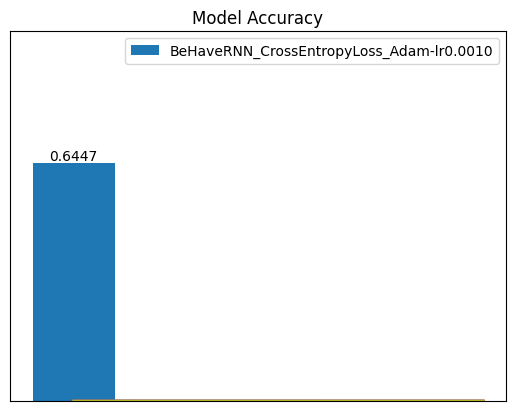

In [165]:
BEHAVE_CONTEXT_SIZE = 20
BEHAVE_BATCH_SIZE = 8192
BEHAVE_EPOCHS = 5
BEHAVE_WORDS = ['<unk>', 'be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
BEHAVE_WORDS_SIZE = len(BEHAVE_WORDS)

class BeHaveRNN(nn.Module):
    def __init__(self):
        super(BeHaveRNN, self).__init__()

        # self.rnn = nn.RNN(EMBEDDINGS_DIM*BEHAVE_CONTEXT_SIZE, EMBEDDINGS_DIM, batch_first=True).to(device)
        self.rnn = nn.RNN(EMBEDDINGS_DIM, EMBEDDINGS_DIM, batch_first=True).to(device)
        self.fc1 = nn.Linear(EMBEDDINGS_DIM, BEHAVE_WORDS_SIZE * 4).to(device)
        self.fc2 = nn.Linear(BEHAVE_WORDS_SIZE * 4, BEHAVE_WORDS_SIZE).to(device)
        self.hidden = None

    def reset(self):
        self.hidden = None

    def forward(self, x):
        x = embeddings[x]

        # Reset the state if its incompatible with current input
        if self.hidden is not None and self.hidden.size(1) != x.size(0):
            self.reset()

        x, hidden = self.rnn(x, self.hidden)
        x = x[:, -1, :] # Keep only the last output
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.log_softmax(x, dim=1)

        self.hidden = hidden.data

        return x

class BeHaveAlways(nn.Module):
    def __init__(self, word):
        super(BeHaveAlways, self).__init__()
        self.name = "Always_" + word
        self.label = BEHAVE_WORDS.index(word)

    def forward(self, x):
        x = torch.zeros(x.size(0), BEHAVE_WORDS_SIZE)
        x[:, self.label] = 1.0
        return x.to(device)

class BeHaveMLP(nn.Module):
    def __init__(self):
        super(BeHaveMLP, self).__init__()
        FC2_SCALE = 16
        FC3_SCALE = 4

        self.fc1 = nn.Linear(EMBEDDINGS_DIM*BEHAVE_CONTEXT_SIZE, EMBEDDINGS_DIM).to(device)
        self.fc2 = nn.Linear(EMBEDDINGS_DIM, BEHAVE_WORDS_SIZE * FC2_SCALE).to(device)
        self.fc3 = nn.Linear(BEHAVE_WORDS_SIZE * FC2_SCALE, BEHAVE_WORDS_SIZE * FC3_SCALE).to(device)
        self.fc4 = nn.Linear(BEHAVE_WORDS_SIZE * FC3_SCALE, BEHAVE_WORDS_SIZE).to(device)

    def forward(self, x):
        x = embeddings[x]
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = torch.log_softmax(self.fc4(x), dim=1)
        return x

def behave_create_dataset(
    words: list[str],
    dataset_name: str
):
    """
    Creates a dataset from the given words.  
    """
    label_to_vocabulary:dict[int, int] = {}

    vocabulary_to_label = { vocabulary[word]: None for word in vocabulary.lookup_tokens(range(VOCABULARY_SIZE)) }

    for label, word in enumerate(BEHAVE_WORDS):

        # Skip '<unk>' to avoid bias to just guess <unk>
        if word == '<unk>': continue

        vocabulary_index = vocabulary[word]

        vocabulary_to_label[vocabulary_index] = label
        label_to_vocabulary[label] = vocabulary_index

    return dataset_create(
        words, 
        context_size_before=BEHAVE_CONTEXT_SIZE / 2, 
        context_size_after=BEHAVE_CONTEXT_SIZE / 2, 
        vocabulary_index_to_target=vocabulary_to_label, 
        dataset_name='behave.'+dataset_name
    ), label_to_vocabulary

def behave_rnn_train(
    dataset: TensorDataset,
    model: BeHaveRNN,
    criterion: object,
    optimizer: torch.optim.Optimizer
) -> list[tuple[int, float]]: 

    model.name = model_nameof(model, criterion, optimizer)

    if model_load(model, 'behave'):
        return
    
    losses = []

    # Train with different sequence lengths
    for context_size in range(0, (BEHAVE_CONTEXT_SIZE // 2) - 1):
        contexts = dataset.tensors[0][:,context_size:BEHAVE_CONTEXT_SIZE - context_size]
        targets = dataset.tensors[1]

        print("Context size:", context_size, contexts.shape)
        
        losses.append(model_train(
            model, TensorDataset(contexts, targets), criterion, optimizer, 
            model_category='behave',
            epochs=BEHAVE_EPOCHS, 
            batch_size=BEHAVE_BATCH_SIZE,
            tranform_targets=lambda x: torch.nn.functional.one_hot(x, num_classes=BEHAVE_WORDS_SIZE).float(),
            retrain=True,
            figure_tag=f'_context-{context_size}'
        ))

        model.reset()

    plt.clf()
    for i, loss in enumerate(losses):
        plt.plot(loss, label=f'Context size {i+1}')
    plt.title(f'{model.name} | Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(DOCS_DIR + f'loss_{model.name}.png')

    model_save(model, 'behave')

def behave_mlp_train(
    dataset: TensorDataset,
    model: BeHaveMLP,
    criterion: object,
    optimizer: torch.optim.Optimizer
) -> list[tuple[int, float]]: 
    
    model_train(
        model, dataset, 
        criterion, 
        optimizer,
        model_category='behave',
        epochs=BEHAVE_EPOCHS, batch_size=BEHAVE_BATCH_SIZE,
        tranform_targets=lambda x: torch.nn.functional.one_hot(x, num_classes=BEHAVE_WORDS_SIZE).float()
    )

def behave_performance(
    model: nn.Module,
    dataset: TensorDataset,
    dataset_name: str = 'Validation'
):
    return model_accuracy(
        model, dataset, dataset_name,
        transform_outputs=lambda x: torch.argmax(x, dim=1)
    )


def behave_create_model():

    print("Training be/have models")
    training_data, label_to_vocabulary = behave_create_dataset(words_train, 'train')

    rnn1 = BeHaveRNN()
    behave_rnn_train(
        training_data, rnn1, 
        nn.CrossEntropyLoss(), 
        torch.optim.Adam(rnn1.parameters(), lr=0.001)
    )
    
    # rnn2 = BeHaveRNN()
    # behave_rnn_train(
    #     training_data, rnn2, 
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.Adam(rnn2.parameters(), lr=0.002)
    # )

    # rnn3 = BeHaveRNN()
    # behave_rnn_train(
    #     training_data, rnn3, 
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.Adam(rnn3.parameters(), lr=0.003)
    # )

    # rnn4 = BeHaveRNN()
    # behave_rnn_train(
    #     training_data, rnn4, 
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.SGD(rnn4.parameters(), lr=0.001)
    # )

    # rnn5 = BeHaveRNN()
    # behave_rnn_train(
    #     training_data, rnn5, 
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.SGD(rnn5.parameters(), lr=0.01)
    # )

    # rnn6 = BeHaveRNN()
    # behave_rnn_train(
    #     training_data, rnn6, 
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.Adam(rnn6.parameters(), lr=0.0001)
    # )

    # mlp1 = BeHaveMLP()
    # behave_mlp_train(
    #     training_data, mlp1,
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.Adam(mlp1.parameters(), lr=0.001)
    # )

    # mlp2 = BeHaveMLP()
    # behave_mlp_train(
    #     training_data, mlp2,
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.Adam(mlp2.parameters(), lr=0.0001)
    # )

    # mlp3 = BeHaveMLP()
    # behave_mlp_train(
    #     training_data, mlp3,
    #     nn.CrossEntropyLoss(), 
    #     torch.optim.SGD(mlp3.parameters(), lr=0.0001)
    # )

    alwaysUnknown = BeHaveAlways('<unk>')

    print("Validating be/have models")

    validation_data, _ = behave_create_dataset(words_val, 'val')

    best_model, validation_accuracy = model_pick_best(
        # [rnn1, rnn2, rnn3, rnn4, rnn5, rnn6, mlp1, mlp2, mlp3, alwaysUnknown], 
        [rnn1], 
        validation_data, 
        behave_performance,
        figure_tag='_behave'
    )

    # test_data, _ = behave_create_dataset(words_test, 'test')
    # test_accuracy = behave_performance(best_model, test_data, 'Test')
    # train_accuracy = behave_performance(best_model, training_data, 'Train')

    # plt.clf()
    # plt.bar(['Train', 'Validation', 'Test'], [train_accuracy, validation_accuracy, test_accuracy])
    # plt.title('Be/Have Model Accuracy')
    # plt.xlabel('Dataset')
    # plt.ylabel('Accuracy')
    # plt.ylim(0.0, 1.0)
    # plt.savefig(DOCS_DIR + 'accuracy_behave_best.png')
    # plt.show()

    return best_model
     

behave_model = behave_create_model()

In [175]:
def behave_try(before: str, after:str):
    behave_model.to(device)
    behave_model.eval()
    behave_model.reset()
    
    words_before = TOKENIZER(before)
    words_after = TOKENIZER(after)

    if len(words_before) != len(words_after):
        print("Contexts must have the same length")
        return

    context = torch.zeros(1, len(words_before) + len(words_after)).long().to(device)
    for i, word in enumerate(words_before):
        context[0, i] = vocabulary[word]
    for i, word in enumerate(words_after):
        context[0, i + len(words_before)] = vocabulary[word]

    output = behave_model(context)
    print(output)

    print((output / output.norm()).abs())

    output = torch.argmax(output, dim=1).item()

    word = BEHAVE_WORDS[output]
    
    print(f'{before} | {word} | {after}')


# Not great
behave_try("When we", "younger we")

tensor([[-9.5502, -2.0161, -3.8378, -1.7402, -1.6109, -2.4095, -2.5988, -3.1170,
         -4.3467, -2.0176, -3.4821, -2.5694, -4.7973]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([[0.6709, 0.1416, 0.2696, 0.1223, 0.1132, 0.1693, 0.1826, 0.2190, 0.3054,
         0.1417, 0.2446, 0.1805, 0.3370]], device='cuda:0',
       grad_fn=<AbsBackward0>)
When we | is | younger we


# Text generation